# Dataset Information Creation
Create a json file to represent the files inside the dataset

In [43]:
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import numpy as np
import json
import torchaudio
import torchaudio.transforms as T
import torch.nn.functional as F
from tqdm import tqdm
from models.vanilla_cnn import AudioCNN
from models.deeper_cnn import DeeperCNN
from models.more_deeper_cnn import MoreDeeperCNN
import torch.nn as nn
from utils import specs_generation, collect_samples
import os

In [44]:
# sudo modprobe nvidia_uvm
torch.cuda.is_available()

True

In [45]:
DATASET_NAME = "DATASET_CNN"
DATASET_PATH = f'/home/giacomoschiavo/segments/{DATASET_NAME}'
TRAIN_PATH = f"{DATASET_PATH}/train"
TEST_PATH = f"{DATASET_PATH}/test"
MODEL_NAME = 'more_deeper_cnn'

# Create Dataset Config

In [46]:
test_species = os.listdir(TEST_PATH) 

In [47]:
with open("utils/category_annots.json") as f:
    category_annots = json.load(f)

filtered_species = [species for species in category_annots.keys() if len(species.split("_")) > 1 and species in test_species]
mappings = {species: i for i, species in enumerate(filtered_species)}
mappings

{'Regulus ignicapilla_Common Firecrest': 0,
 'Sylvia atricapilla_Eurasian Blackcap': 1,
 'Fringilla coelebs_Common Chaffinch': 2,
 'Troglodytes troglodytes_Eurasian Wren': 3,
 'Muscicapa striata_Spotted Flycatcher': 4,
 'Glaucidium passerinum_Eurasian Pygmy-Owl': 5,
 'Pyrrhula pyrrhula_Eurasian Bullfinch': 6,
 'Periparus ater_Coal Tit': 7,
 'Lophophanes cristatus_Crested Tit': 8,
 'Regulus regulus_Goldcrest': 9,
 'Turdus merula_Eurasian Blackbird': 10,
 'Certhia familiaris_Eurasian Treecreeper': 11,
 'Erithacus rubecula_European Robin': 12,
 'Turdus philomelos_Song Thrush': 13,
 'Loxia curvirostra_Common Crossbill': 14,
 'Dendrocopos major_Great Spotted Woodpecker': 15,
 'Dryocopus martius_Black Woodpecker': 16}

In [48]:
samples = collect_samples(TRAIN_PATH, TEST_PATH, mappings)

In [49]:
dataset_config = {
    "mappings": mappings,
    "samples": samples
}

## Choose the model here

In [52]:
model = MoreDeeperCNN(len(mappings))

In [53]:
with open(f"utils/{DATASET_NAME}/dataset_config.json", "w") as f:
    json.dump(dataset_config, f)

# Spectograms Creation

In [54]:
import os
import torchaudio
import torch
import torch.nn.functional as F

def specs_generation(input_path, output_path, mappings):
    sample_rate = 32000
    target_samples = sample_rate * 3
    n_fft = 1024
    hop_length = 256
    win_length = 1024

    for species in os.listdir(input_path):
        if species not in mappings:
            continue
        species_path = os.path.join(input_path, species)
        output_species_path = os.path.join(output_path, species)
        os.makedirs(output_species_path, exist_ok=True)

        print(f"Processing: {species}")

        for audio in os.listdir(species_path):
            audio_name = os.path.splitext(audio)[0]
            save_path = os.path.join(output_species_path, f"{audio_name}.pt")
            if os.path.exists(save_path):
                continue
            audio_path = os.path.join(species_path, audio)
            waveform, sr = torchaudio.load(audio_path)

            if sr != sample_rate:
                resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=sample_rate)
                waveform = resampler(waveform)

            if waveform.shape[1] < target_samples:
                pad_len = target_samples - waveform.shape[1]
                waveform = F.pad(waveform, (0, pad_len))
            else:
                waveform = waveform[:, :target_samples]

            waveform = waveform[0:1, :]  # keep solo il primo canale

            window = torch.hann_window(n_fft, device=waveform.device)

            stft = torch.stft(
                waveform,
                n_fft=n_fft,
                hop_length=hop_length,
                win_length=win_length,
                window=window,
                return_complex=True
            )
            spectrogram = torch.abs(stft)  # shape: (freq, time)

            # Optional log scaling or 
            spectrogram = torch.log1p(spectrogram)
            # spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min())

            # Resize to 256x256
            spectrogram = spectrogram.unsqueeze(0) # (1, 1, freq, time)
            spectrogram = F.interpolate(spectrogram, size=(256, 256), mode="bilinear", align_corners=False)
            spectrogram = spectrogram.squeeze(0).squeeze(0)  # torna a (256, 256)

            # Save the spectrogram tensor
            torch.save(spectrogram, save_path)

In [55]:
SPECS_TRAIN_PATH = f"{DATASET_PATH}/train_specs"
SPECS_TEST_PATH = f"{DATASET_PATH}/test_specs"
os.makedirs(SPECS_TRAIN_PATH, exist_ok=True)
os.makedirs(SPECS_TEST_PATH, exist_ok=True)
specs_generation(TRAIN_PATH, SPECS_TRAIN_PATH, dataset_config['mappings'])
specs_generation(TEST_PATH, SPECS_TEST_PATH, dataset_config['mappings'])

Processing: Muscicapa striata_Spotted Flycatcher
Processing: Periparus ater_Coal Tit
Processing: Regulus regulus_Goldcrest
Processing: Glaucidium passerinum_Eurasian Pygmy-Owl
Processing: Troglodytes troglodytes_Eurasian Wren
Processing: Erithacus rubecula_European Robin
Processing: Dryocopus martius_Black Woodpecker
Processing: Certhia familiaris_Eurasian Treecreeper
Processing: Pyrrhula pyrrhula_Eurasian Bullfinch
Processing: Turdus merula_Eurasian Blackbird
Processing: Loxia curvirostra_Common Crossbill
Processing: Regulus ignicapilla_Common Firecrest
Processing: Dendrocopos major_Great Spotted Woodpecker
Processing: Sylvia atricapilla_Eurasian Blackcap
Processing: Lophophanes cristatus_Crested Tit
Processing: Fringilla coelebs_Common Chaffinch
Processing: Turdus philomelos_Song Thrush
Processing: Muscicapa striata_Spotted Flycatcher
Processing: Periparus ater_Coal Tit
Processing: Regulus regulus_Goldcrest
Processing: Glaucidium passerinum_Eurasian Pygmy-Owl
Processing: Troglodytes 

Shape: torch.Size([256, 256])


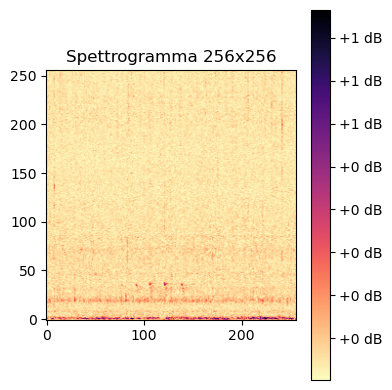

In [56]:
# carica lo spettrogramma salvato
spec_path = "/home/giacomoschiavo/segments/DATASET_CNN/train_specs/Turdus merula_Eurasian Blackbird/20190621_160000_64_5.pt"  # cambia path se serve
spec = torch.load(spec_path)

# controlla la shape per capire cosa stai guardando
print("Shape:", spec.shape)  # dovrebbe essere (256, 256)

# Plot semplice e clean
plt.figure(figsize=(4, 4))
plt.imshow(spec.numpy(), origin='lower', cmap='magma_r')
plt.title("Spettrogramma 256x256")
plt.colorbar(format="%+2.f dB")
plt.tight_layout()
plt.show()


# Dataset and Data Loader
Use the dataset information to create a data loader for the model

In [57]:
def wav_to_spec(audio_path):
    split = audio_path.split("/")[-3]
    audio = audio_path.replace("wav", "pt").replace(split, f"{split}_specs")
    return audio

In [58]:
class CachedAudioDataset(Dataset):
    def __init__(self, dataset_config, split="train"):
        self.samples = [s for s in dataset_config["samples"] if s["split"] == split]
        self.num_classes = len(dataset_config["mappings"])
        
        # Carica tutto in RAM
        self.cache = []
        for sample in self.samples:
            spec = torch.load(wav_to_spec(sample["file_path"]))  # spettrogramma
            label_tensor = torch.zeros(self.num_classes)
            for label in sample["labels"]:
                label_tensor[label] = 1.0
            self.cache.append((spec, label_tensor, sample["file_path"]))

    def __len__(self):
        return len(self.cache)

    def __getitem__(self, idx):
        return self.cache[idx]


In [59]:
from torch.utils.data import DataLoader

def get_dataloader(dataset_config, split="train", batch_size=100, shuffle=True):
    dataset = CachedAudioDataset(dataset_config=dataset_config, split=split)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Model

In [ ]:
def train_model(dataset_config, model, model_name, epochs=10, batch_size=100, lr=1e-5, patience=3, early_stop_patience=5, print_freq=100, reset_weights=False, history_loss=[]):
    history_loss = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on: {device}")

    print("Loading training data...")
    train_loader = get_dataloader(dataset_config, split="train", batch_size=batch_size)
    print("Loaded!")

    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=patience, threshold=1e-3
    )

    saving_path = f'models/saved_checkpoints/{model_name}_checkpoint.pth'
    if os.path.exists(saving_path) or reset_weights is True:
        checkpoint = torch.load(saving_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    best_loss = float("inf")
    early_stop_counter = 0


    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        print(f"\n🎯 Starting epoch {epoch + 1}/{epochs}")

        for batch_index, (mel_spec, labels, _) in enumerate(train_loader):
            mel_spec = mel_spec.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(mel_spec)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            if batch_index % print_freq == 0:
                print('Epoch: [{0}][{1}/{2}], Loss: {loss:.5f}'.format(epoch, batch_index, len(train_loader), loss=loss))

        avg_loss = running_loss / len(train_loader)
        history_loss.append(running_loss)
        scheduler.step(running_loss)

        if avg_loss < best_loss:
            best_loss = avg_loss
            early_stop_counter = 0
            print(f"💾 Saving improved model at epoch {epoch+1} with avg_loss={avg_loss:.5f}")
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'avg_loss': avg_loss,
            }, saving_path)
        else:
            early_stop_counter += 1
            print(f"🛑 No improvement — early stop counter: {early_stop_counter}/{early_stop_patience}")

        print(f"🔁 Epoch {epoch+1} completed - Avg loss: {avg_loss:.5f} - LR: {optimizer.param_groups[0]['lr']:.1e}")

        if early_stop_counter >= early_stop_patience:
            print(f"\n🚨 Early stopping triggered after {early_stop_patience} epochs without improvement.")
            break

    print("✅ Training completed")
    return model


In [61]:
history_loss = []

In [62]:
model, history_loss = train_model(dataset_config, model, MODEL_NAME, epochs=100, batch_size=64, lr=1e-3, history_loss=history_loss)

Training on: cuda
Loading training data...
Loaded!

🎯 Starting epoch 1/100
Epoch: [0][0/254], Loss: 0.70434
Epoch: [0][100/254], Loss: 0.22015
Epoch: [0][200/254], Loss: 0.17775
💾 Saving improved model at epoch 1 with avg_loss=0.22668
🔁 Epoch 1 completed - Avg loss: 0.22668 - LR: 1.0e-03

🎯 Starting epoch 2/100
Epoch: [1][0/254], Loss: 0.21737
Epoch: [1][100/254], Loss: 0.13763
Epoch: [1][200/254], Loss: 0.14561
💾 Saving improved model at epoch 2 with avg_loss=0.15044
🔁 Epoch 2 completed - Avg loss: 0.15044 - LR: 1.0e-03

🎯 Starting epoch 3/100
Epoch: [2][0/254], Loss: 0.14478
Epoch: [2][100/254], Loss: 0.14393
Epoch: [2][200/254], Loss: 0.15369
💾 Saving improved model at epoch 3 with avg_loss=0.12868
🔁 Epoch 3 completed - Avg loss: 0.12868 - LR: 1.0e-03

🎯 Starting epoch 4/100
Epoch: [3][0/254], Loss: 0.12799
Epoch: [3][100/254], Loss: 0.11140
Epoch: [3][200/254], Loss: 0.12311
💾 Saving improved model at epoch 4 with avg_loss=0.11836
🔁 Epoch 4 completed - Avg loss: 0.11836 - LR: 1.0e-

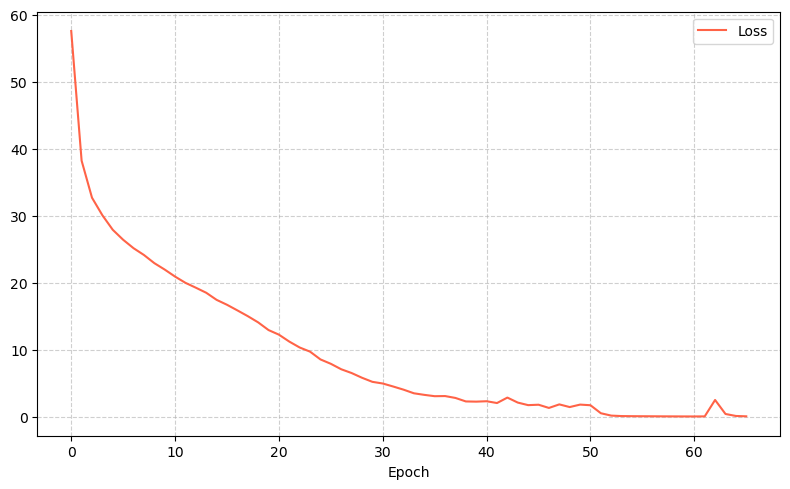

In [63]:
plt.figure(figsize=(8, 5))
plt.plot(history_loss, linestyle='-', color='tomato', label="Loss")
# plt.title(title)
plt.xlabel("Epoch")
# plt.ylabel(ylabel)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [64]:
# model = AudioCNN(len(mappings))
# saving_path = f'models/saved_checkpoints/{MODEL_NAME}_checkpoint.pth'
# checkpoint = torch.load(saving_path)
# model.load_state_dict(checkpoint['model_state_dict'])

# Custom Thresholds Creation

In [65]:
from collections import defaultdict
from sklearn.metrics import f1_score

def calculate_conf_scores(valid_loader, model, mappings):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)
    
    conf_scores = defaultdict(list)

    with torch.no_grad():
        for mel_spec, _, file_path in valid_loader:
            mel_spec = mel_spec.to(device)

            # Estraggo la specie corretta dal path
            correct_species = file_path[0].split("/")[-2]
            outputs = model(mel_spec)
            probs = torch.sigmoid(outputs)[0].cpu().numpy()

            for i, prob in enumerate(probs):
                species_name = list(mappings.keys())[i]
                is_correct = (species_name == correct_species)
                conf_scores[species_name].append((prob, is_correct))

    return conf_scores

# Step 2: Trova la soglia migliore per ciascuna specie
def compute_best_thresholds(conf_scores, num_thresholds=100):
    thresholds = {}

    for species, values in conf_scores.items():
        probs, truths = zip(*values)
        probs = np.array(probs)
        truths = np.array(truths).astype(int)

        best_thresh = 0.5
        best_f1 = 0.0

        for thresh in np.linspace(0, 1, num_thresholds):
            preds = (probs >= thresh).astype(int)
            f1 = f1_score(truths, preds, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh

        thresholds[species] = best_thresh
        print(f"📊 Specie: {species}, Best Threshold: {best_thresh:.3f}, F1-score: {best_f1:.3f}")

    return thresholds



In [66]:
valid_loader = get_dataloader(dataset_config, split="valid", batch_size=1)
conf_scores = calculate_conf_scores(valid_loader, model, dataset_config["mappings"])
best_thresholds = compute_best_thresholds(conf_scores)

📊 Specie: Regulus ignicapilla_Common Firecrest, Best Threshold: 0.495, F1-score: 0.656
📊 Specie: Sylvia atricapilla_Eurasian Blackcap, Best Threshold: 0.990, F1-score: 0.805
📊 Specie: Fringilla coelebs_Common Chaffinch, Best Threshold: 0.919, F1-score: 0.573
📊 Specie: Troglodytes troglodytes_Eurasian Wren, Best Threshold: 0.030, F1-score: 0.714
📊 Specie: Muscicapa striata_Spotted Flycatcher, Best Threshold: 0.727, F1-score: 0.865
📊 Specie: Glaucidium passerinum_Eurasian Pygmy-Owl, Best Threshold: 0.010, F1-score: 0.800
📊 Specie: Pyrrhula pyrrhula_Eurasian Bullfinch, Best Threshold: 0.020, F1-score: 0.667
📊 Specie: Periparus ater_Coal Tit, Best Threshold: 0.081, F1-score: 0.754
📊 Specie: Lophophanes cristatus_Crested Tit, Best Threshold: 0.051, F1-score: 0.690
📊 Specie: Regulus regulus_Goldcrest, Best Threshold: 0.131, F1-score: 0.881
📊 Specie: Turdus merula_Eurasian Blackbird, Best Threshold: 0.091, F1-score: 0.785
📊 Specie: Certhia familiaris_Eurasian Treecreeper, Best Threshold: 0.11

# Test Model

In [71]:
import numpy as np
from sklearn.metrics import classification_report

def test_model(model, dataset_config, batch_size=100, thresholds=0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n🧬 Advanced testing on: {device}")

    test_loader = get_dataloader(dataset_config, split="test", batch_size=batch_size, shuffle=False)
    model.eval()
    criterion = nn.BCEWithLogitsLoss()
    class_names = list(dataset_config['mappings'].keys())
    total_loss = 0.0
    all_preds = []
    all_probs = []
    all_labels = []

    use_custom_threshold = isinstance(thresholds, dict)

    with torch.no_grad():
        for mel_spec, labels, _ in test_loader:
            mel_spec = mel_spec.to(device)
            labels = labels.to(device)

            outputs = model(mel_spec)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(outputs)

            if use_custom_threshold:
                batch_preds = torch.zeros_like(probs)
                for i, class_name in enumerate(class_names):
                    thresh = thresholds.get(class_name, 0.5)
                    batch_preds[:, i] = (probs[:, i] > thresh).float()
            else:
                batch_preds = (probs > thresholds).float()

            all_probs.append(probs.cpu())
            all_preds.append(batch_preds.cpu())
            all_labels.append(labels.cpu())

    avg_loss = total_loss / len(test_loader)
    all_probs = torch.cat(all_probs).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # 👇 Report
    clf_report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    return avg_loss, clf_report, all_probs, all_labels, all_preds


In [72]:
avg_loss, clf_report, all_probs, all_labels, all_preds = test_model(model, dataset_config, thresholds=best_thresholds)


🧬 Advanced testing on: cuda


/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [73]:
from io import StringIO
import pandas as pd

clf_report_df = pd.read_json(StringIO(json.dumps(clf_report)), orient='index')
clf_report_df

,precision,recall,f1-score,support
Regulus ignicapilla_Common Firecrest,0.541463,0.404617,0.463143,823
Sylvia atricapilla_Eurasian Blackcap,0.369541,0.456747,0.408542,1445
Fringilla coelebs_Common Chaffinch,0.598291,0.103627,0.176656,2702
Troglodytes troglodytes_Eurasian Wren,0.263889,0.127517,0.171946,149
Muscicapa striata_Spotted Flycatcher,1.000000,0.113208,0.203390,159
Glaucidium passerinum_Eurasian Pygmy-Owl,0.000000,0.000000,0.000000,27
Pyrrhula pyrrhula_Eurasian Bullfinch,0.434783,0.322581,0.370370,31
Periparus ater_Coal Tit,0.129032,0.026490,0.043956,151
Lophophanes cristatus_Crested Tit,0.000000,0.000000,0.000000,43
Regulus regulus_Goldcrest,0.240506,0.133803,0.171946,142


In [70]:
index = 1
all_probs[index], all_labels[index], all_preds[index]

(array([7.2053903e-05, 4.7081760e-03, 1.5122401e-10, 5.2503547e-13,
        1.6520668e-27, 8.6191112e-34, 1.5661196e-22, 2.5912146e-09,
        2.2178499e-17, 1.4515227e-06, 5.9883124e-01, 3.2173703e-14,
        4.1282709e-14, 3.8392588e-12, 8.6660325e-25, 4.1849864e-11,
        2.6562038e-23], dtype=float32),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       dtype=float32))